In [6]:
import sklearn
if '0.22' != sklearn.__version__:
  !pip3 install scikit-plot
  !pip install -U scikit-learn
  import os
  os.kill(os.getpid(), 9)

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

#%load_ext tensorboard

%pylab inline
plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (6,6)

import random as rn
import pandas as pd
import xarray
import requests
import datetime

import os
import numpy as np
from datetime import timedelta
from tqdm import tqdm_notebook as tqdm
import sklearn as skl
import seaborn as sns
import xgboost as xgb
from pathlib import Path
import scikitplot as skplt
#from google.colab import files, drive
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt

#import tensorflow as tf
#import tensorflow.keras as keras

#print(tf.test.gpu_device_name())
#print(tf.__version__)
#print(keras.__version__)
#print(sklearn.__version__)
#assert ('0.22' == sklearn.__version__)

#from keras import layers
#from keras.callbacks import TensorBoard
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold, RandomizedSearchCV, cross_val_score, cross_val_score
from sklearn.calibration import CalibratedClassifierCV
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import resample
from sklearn.pipeline import make_pipeline
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
import sklearn.ensemble

import warnings
warnings.filterwarnings('ignore')
#logger = tf.get_logger()
#logger.setLevel(logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.6f}'.format

RS = 77
rn.seed(RS)
#tf.random.set_seed(RS)
np.random.seed(RS)
np.random.RandomState(RS)

#GDRIVE_PATH = '/content/gdrive'
#drive.mount(GDRIVE_PATH)
#OTT_PATH = os.path.join(GDRIVE_PATH, 'My Drive/OTT', '')

Populating the interactive namespace from numpy and matplotlib


In [7]:
def anti_scaler(X):
  #Anti-StandardScaler для Field1 и Field14 тиснуто отсюда https://github.com/IlyaSviridov/OneTwoTrip-Contest/blob/master/EDA_fields_1.ipynb
  unique14 = np.unique(X['field14'])
  new_unique14 = np.round(unique14 / 0.14006639 - 0.27860731).astype(int)
  dict14 = {unique14[i]: new_unique14[i] for i in range(len(unique14))}
  X['field14'] = X['field14'].apply(lambda x: dict14[x])

  unique1 = np.unique(X['field1'])
  new_unique1 = np.round(unique1  / 0.077571 + 0.0765905).astype(int)
  dict1 = {unique1[i]: new_unique1[i] for i in range(len(unique1))}
  X['field1'] = X['field1'].apply(lambda x: dict1[x])
  return X

df_train = pd.read_csv('https://boosters.pro/api/ch/files/pub/onetwotrip_challenge_train.csv', index_col='orderid') #, dtype={'field1': np.float64, 'field14': np.float64})
df_test = pd.read_csv('https://boosters.pro/api/ch/files/pub/onetwotrip_challenge_test.csv', index_col='orderid') #, dtype={'field1': np.float64, 'field14': np.float64})

df_train, df_oof = train_test_split(df_train, random_state=RS, shuffle=True, test_size=0.1)

df_train = anti_scaler(df_train)
df_test = anti_scaler(df_test)
df_oof = anti_scaler(df_oof)

TARGET = 'goal1'
FTS = list(filter(lambda x: 'field' in x, df_train.columns))

df_train.head()

,userid,field0,field1,field2,field3,field4,field5,field6,field7,field8,...,indicator_goal22,indicator_goal23,indicator_goal24,indicator_goal25,goal21,goal22,goal23,goal24,goal25,goal1
orderid,,,,,,,,,,,,,,,,,,,,,
126862,c2da187607dcd6243a1d32baa68168d70337bdadf5dabc...,0,4,8,8,1,1,0,1,1,...,1,0,1,1,0,1,0,0,0,0
195018,d1516685f5bd283f8a9c11790eadc2e33d554379be2260...,0,-2,8,8,1,1,0,2,1,...,1,1,1,1,0,1,1,0,0,0
36083,40dca0bcacbb5dcd4898cd1d5354853981d64112285f2c...,0,-4,6,6,1,1,0,1,1,...,1,0,0,0,0,0,0,0,0,0
114781,61adbd9a60a346a815fbbdd39603a295079c2a0ef60c72...,0,-4,10,10,1,1,0,1,1,...,1,1,0,1,0,0,0,0,0,0
74627,8b43596cc465424e92446db00d83b4f3d9b871c73f38d7...,0,-7,8,9,1,1,0,1,1,...,1,0,1,0,0,0,0,0,0,0


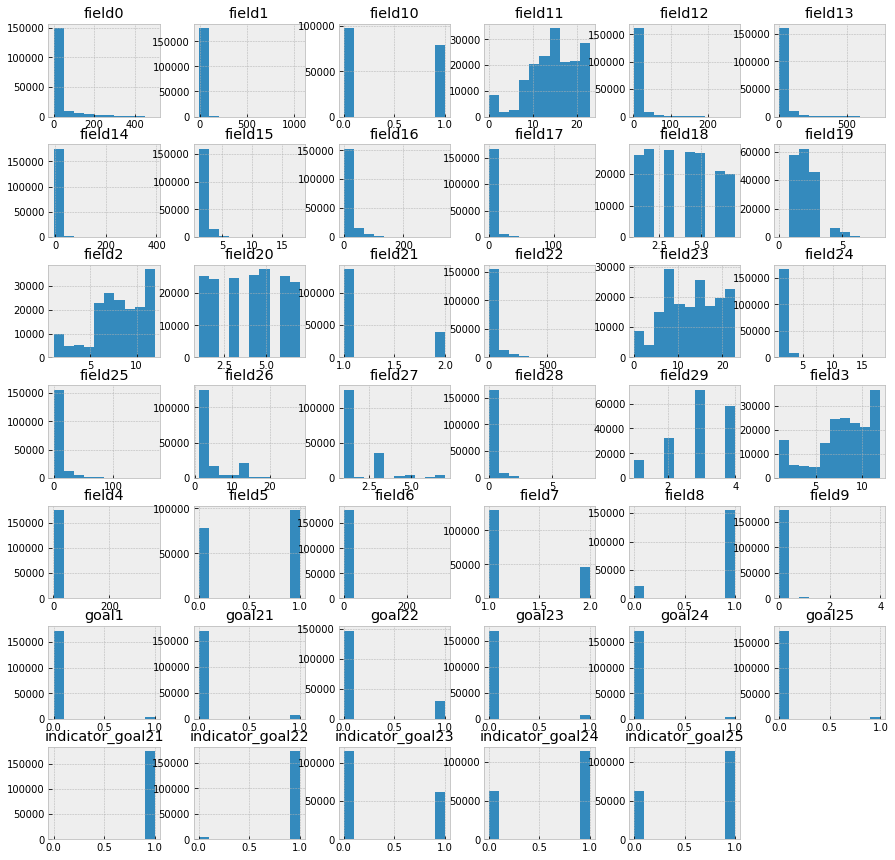

In [8]:
fig, ax = plt.subplots(figsize=(15,15))
df_train.hist(ax=ax);

## Helper functions

In [9]:
def get_anomaly_scores(originalDF, reducedDF):
    loss = np.sum((np.array(originalDF)-np.array(reducedDF))**2, axis=1)
    loss = pd.Series(data=loss,index=originalDF.index)
    loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
    return loss

def plotResults(trueLabels, anomalyScores, returnPreds=False):
    preds = pd.concat([trueLabels, anomalyScores], axis=1)
    preds.columns = ['trueLabel', 'anomalyScore']
    precision, recall, thresholds = \
        skl.metrics.precision_recall_curve(preds['trueLabel'],preds['anomalyScore'])
    average_precision = \
        skl.metrics.average_precision_score(preds['trueLabel'],preds['anomalyScore'])

    fpr, tpr, thresholds = skl.metrics.roc_curve(preds['trueLabel'], preds['anomalyScore'])
    areaUnderROC = skl.metrics.auc(fpr, tpr)

    fig = plt.figure()
    #fig = plt.gcf()
    #fig.add_subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC_AUC: {areaUnderROC:.4f}, avg prec: {average_precision:.4f}')
    plt.legend(loc="lower right")

    #fig.add_subplot(1, 2, 2)   
    plt.step(recall, precision, color='k', alpha=0.7, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])

    plt.show()

    if returnPreds==True:
        return preds

def scatterPlot(xDF, yDF, algoName):
    tempDF = pd.DataFrame(data=xDF.loc[:,0:1], index=xDF.index)
    tempDF = pd.concat((tempDF,yDF), axis=1, join="inner")
    tempDF.columns = ["First Vector", "Second Vector", "Label"]
    lm = sns.lmplot(x="First Vector", y="Second Vector", hue="Label", \
               data=tempDF, fit_reg=False)
    ax = plt.gca()
    ax.set_title("Separation of Observations using "+algoName)

    return lm


In [10]:
X = df_train[FTS]
y = df_train[TARGET]

# PCA

In [11]:
from sklearn.decomposition import PCA

def PCA_(n_components, X):
  pca = PCA(n_components=n_components, whiten=False, random_state=RS)

  X_train_PCA = pca.fit_transform(X)
  X_train_PCA = pd.DataFrame(data=X_train_PCA, index=X.index)

  X_train_PCA_inverse = pca.inverse_transform(X_train_PCA)
  X_train_PCA_inverse = pd.DataFrame(data=X_train_PCA_inverse, index=X.index)

  anomalyScoresPCA = get_anomaly_scores(X, X_train_PCA_inverse)

  return anomalyScoresPCA, X_train_PCA

In [12]:
def estimate_n_components(estimator, X, verbose=False):
  NUM_FEATURES = X.shape[1]
  scores = np.zeros(NUM_FEATURES)
  for i in range(1, NUM_FEATURES):
    anomaly_score, _ = estimator(i, X)
    
    fpr, tpr, thresholds = skl.metrics.roc_curve(y, anomaly_score)
    areaUnderROC = skl.metrics.auc(fpr, tpr)

    if verbose == True:
      print(f'n_components={i} AUC={areaUnderROC:.5f}')

    scores[i]=areaUnderROC
  return scores, np.argmax(scores)

scores, index = estimate_n_components(PCA_, X, verbose=True)
print(f'{scores[index]} : {index}')

n_components=1 AUC=0.56878
n_components=2 AUC=0.59546
n_components=3 AUC=0.60945
n_components=4 AUC=0.59876
n_components=5 AUC=0.58971
n_components=6 AUC=0.57869
n_components=7 AUC=0.58436
n_components=8 AUC=0.56371
n_components=9 AUC=0.55300
n_components=10 AUC=0.55793
n_components=11 AUC=0.55879
n_components=12 AUC=0.54083
n_components=13 AUC=0.54218
n_components=14 AUC=0.51173
n_components=15 AUC=0.54333
n_components=16 AUC=0.55931
n_components=17 AUC=0.57270
n_components=18 AUC=0.52648
n_components=19 AUC=0.52783
n_components=20 AUC=0.53225
n_components=21 AUC=0.53558
n_components=22 AUC=0.54882
n_components=23 AUC=0.56127
n_components=24 AUC=0.56066
n_components=25 AUC=0.54103
n_components=26 AUC=0.49880
n_components=27 AUC=0.49397
n_components=28 AUC=0.52865
n_components=29 AUC=0.55637
0.609447650792084 : 3


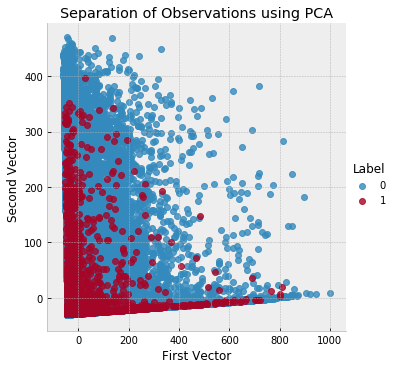

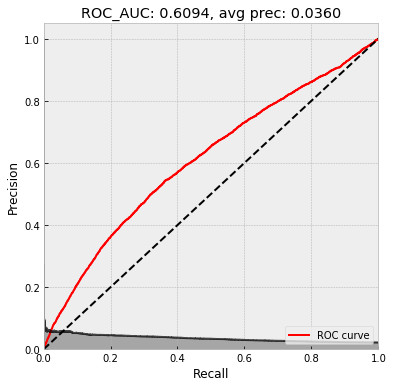

In [13]:
anomalyScores, X_train  = PCA_(3, X)

lm = scatterPlot(X_train, y, "PCA")
preds = plotResults(y, anomalyScores, True)

In [14]:
preds.sort_values(by="anomalyScore",ascending=False,inplace=True)
cutoff = 350
predsTop = preds[:cutoff]
print("Precision: ",np.round(predsTop. \
            anomalyScore[predsTop.trueLabel==1].count()/cutoff,2))
print("Recall: ",np.round(predsTop. \
            anomalyScore[predsTop.trueLabel==1].count()/y.sum(),2))
print(f'Anomalies out of {cutoff} Cases: {predsTop.trueLabel.sum()}')

Precision:  0.06
Recall:  0.01
Anomalies out of 350 Cases: 22


# *SparsePCA*


In [15]:
from sklearn.decomposition import SparsePCA

def SparsePCA_(n_components, X):
  sparsePCA = SparsePCA(n_components=n_components, alpha=0.0001, random_state=RS, n_jobs=-1)

  sparsePCA.fit(X.loc[:,:])
  X_train_sparsePCA = sparsePCA.transform(X)
  X_train_sparsePCA = pd.DataFrame(data=X_train_sparsePCA, index=X.index)

  X_train_sparsePCA_inverse = np.array(X_train_sparsePCA).dot(sparsePCA.components_) + np.array(X.mean(axis=0))
  X_train_sparsePCA_inverse = pd.DataFrame(data=X_train_sparsePCA_inverse, index=X.index)

  anomalyScoresSparsePCA = get_anomaly_scores(X, X_train_sparsePCA_inverse)

  return anomalyScoresSparsePCA, X_train_sparsePCA

In [16]:
scores, index = estimate_n_components(SparsePCA_, X)
print(f'{scores[index]} : {index}')

0.6093326048534763 : 3


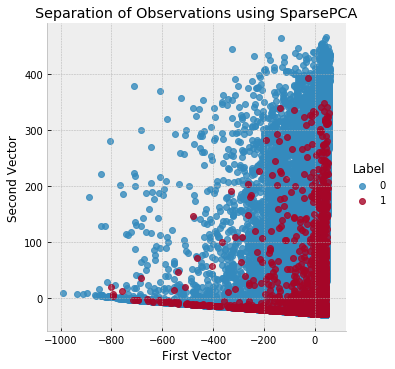

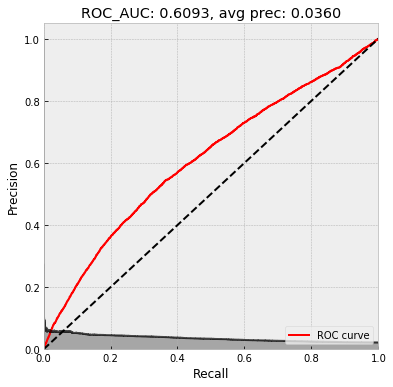

In [17]:
# Sparse PCA
anomalyScores, X_train = SparsePCA_(3, X)

scatterPlot(X_train, y, "SparsePCA")
preds = plotResults(y, anomalyScores, True)

# KernelPCA


In [18]:
from sklearn.decomposition import KernelPCA

def KernelPCA_(n_components, X):
  kernelPCA = KernelPCA(n_components=n_components, kernel='rbf', \
                gamma=None, fit_inverse_transform=True, n_jobs=-1, \
                random_state=RS)

  kernelPCA.fit(X.iloc[:2000])
  X_train_kernelPCA = kernelPCA.transform(X)
  X_train_kernelPCA = pd.DataFrame(data=X_train_kernelPCA, \
                                  index=X.index)

  X_train_kernelPCA_inverse = kernelPCA.inverse_transform(X_train_kernelPCA)
  X_train_kernelPCA_inverse = pd.DataFrame(data=X_train_kernelPCA_inverse, \
                                          index=X.index)

  anomalyScoresKernelPCA = get_anomaly_scores(X, X_train_kernelPCA_inverse)

  return anomalyScoresKernelPCA, X_train_kernelPCA

In [19]:
scores, index = estimate_n_components(KernelPCA_, X, verbose=True)
print(f'{scores[index]} : {index}')

n_components=1 AUC=0.56691
n_components=2 AUC=0.56720
n_components=3 AUC=0.56974
n_components=4 AUC=0.56949
n_components=5 AUC=0.56937
n_components=6 AUC=0.56939
n_components=7 AUC=0.56921
n_components=8 AUC=0.56920
n_components=9 AUC=0.56886
n_components=10 AUC=0.56870
n_components=11 AUC=0.56854
n_components=12 AUC=0.56833
n_components=13 AUC=0.56816
n_components=14 AUC=0.56801
n_components=15 AUC=0.56788
n_components=16 AUC=0.56798
n_components=17 AUC=0.56778
n_components=18 AUC=0.56763
n_components=19 AUC=0.56744
n_components=20 AUC=0.56736
n_components=21 AUC=0.56721
n_components=22 AUC=0.56736
n_components=23 AUC=0.56730
n_components=24 AUC=0.56719
n_components=25 AUC=0.56706
n_components=26 AUC=0.56708
n_components=27 AUC=0.56701
n_components=28 AUC=0.56694
n_components=29 AUC=0.56682
0.5697387459206885 : 3


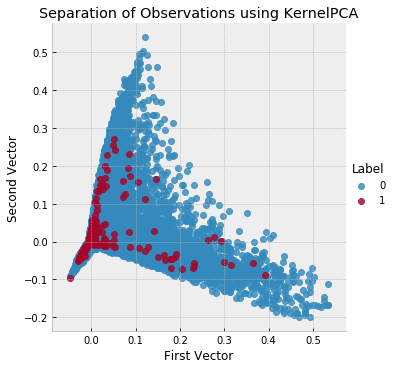

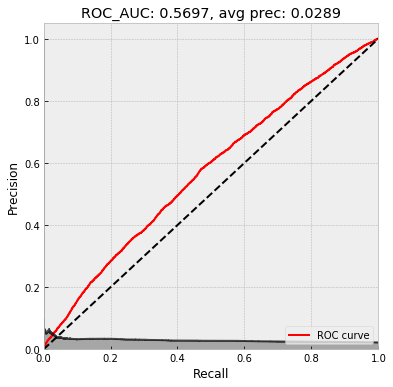

In [20]:
# Kernel PCA
anomalyScores, X_train  = KernelPCA_(3, X)

scatterPlot(X_train, y, "KernelPCA")
preds = plotResults(y, anomalyScores, True)

# GaussianRandomProjection


In [21]:
from sklearn.random_projection import GaussianRandomProjection

def GRP_(n_components, X):
  GRP = GaussianRandomProjection(n_components=n_components, eps=None, random_state=RS)

  X_train_GRP = GRP.fit_transform(X)
  X_train_GRP = pd.DataFrame(data=X_train_GRP, index=X.index)

  X_train_GRP_inverse = np.array(X_train_GRP).dot(GRP.components_)
  X_train_GRP_inverse = pd.DataFrame(data=X_train_GRP_inverse, \
                                    index=X.index)

  anomalyScoresGRP = get_anomaly_scores(X, X_train_GRP_inverse)

  return anomalyScoresGRP, X_train_GRP

In [22]:
scores, index = estimate_n_components(GRP_, X)
print(f'{scores[index]} : {index}')

0.6084230985738577 : 1


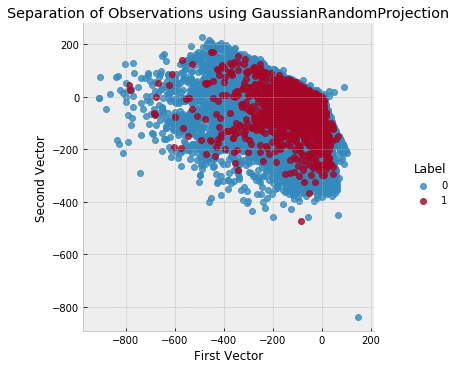

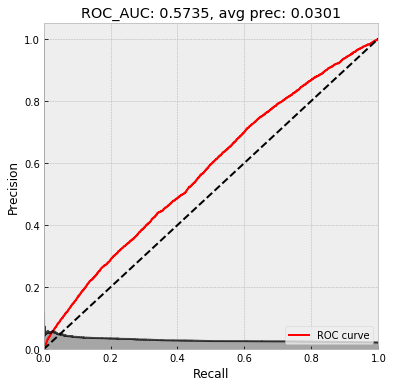

In [23]:
# Gaussian Random Projection
anomalyScores, X_train  = GRP_(3, X)

scatterPlot(X_train, y, "GaussianRandomProjection")
preds = plotResults(y, anomalyScores, True)

# SparseRandomProjection

In [24]:
from sklearn.random_projection import SparseRandomProjection

def SRP_(n_components, X_train):

  SRP = SparseRandomProjection(n_components=n_components, \
          density='auto', eps=.01, dense_output=True, \
                                  random_state=RS)

  X_train_SRP = SRP.fit_transform(X_train)
  X_train_SRP = pd.DataFrame(data=X_train_SRP, index=X_train.index)

  X_train_SRP_inverse = np.array(X_train_SRP).dot(SRP.components_.todense())
  X_train_SRP_inverse = pd.DataFrame(data=X_train_SRP_inverse, index=X_train.index)

  anomalyScoresSRP = get_anomaly_scores(X_train, X_train_SRP_inverse)

  return anomalyScoresSRP, X_train_SRP

In [25]:
scores, index = estimate_n_components(SRP_, X)
print(f'{scores[index]} : {index}')

0.5999263322288828 : 9


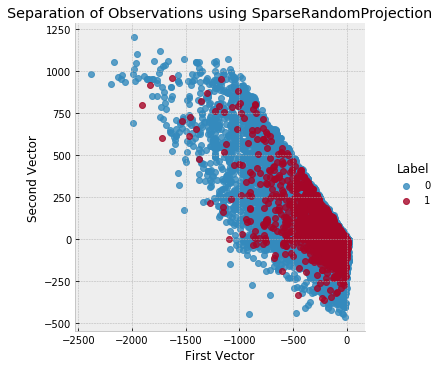

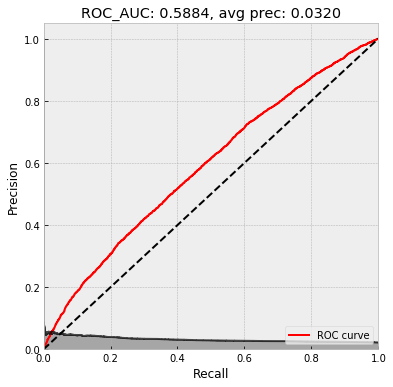

In [26]:
# Sparse Random Projection
anomalyScores, X_train  = SRP_(3, X)

scatterPlot(X_train, y, "SparseRandomProjection")
preds = plotResults(y, anomalyScores, True)

In [27]:
import seaborn as sns
sns.boxplot(x=X['14/4'])

KeyError: '14/4'

In [28]:
df_train['field6'].quantile(0.99)

21.0

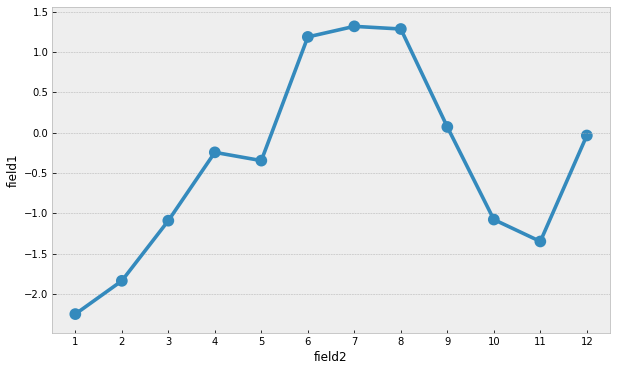

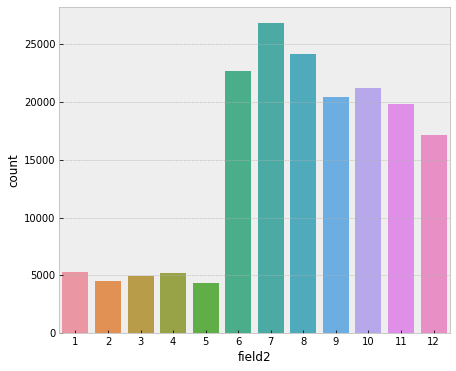

In [29]:
X = df_train

df11 = X.groupby(['field2'])[['field1']].mean()
df11.reset_index(inplace=True)
fig, ax = plt.subplots(figsize=(10, 6))
sns.pointplot(x='field2', y='field1', data=df11, ax=ax);

fig, ax = plt.subplots(figsize=(7, 6))
sns.countplot(X['field2'], ax=ax);
#sns.scatterplot(x='field11', y='field1', data=X, alpha=0.8, ax=ax);

In [30]:
df_train.describe()
df_test.describe()
full = pd.concat([df_train, df_test])
full.describe()

,field0,field1,field10,field11,field12,field13,field14,field15,field16,field17,...,goal21,goal22,goal23,goal24,goal25,indicator_goal21,indicator_goal22,indicator_goal23,indicator_goal24,indicator_goal25
count,631461.000000,631461.000000,631461.000000,631461.000000,631461.000000,631461.000000,631461.000000,631461.000000,631461.000000,631461.000000,...,176450.000000,176450.000000,176450.000000,176450.000000,176450.000000,631461.000000,631461.000000,631461.000000,631461.000000,631461.000000
mean,28.398766,0.076985,0.447822,14.615419,11.986484,27.315188,-0.278877,1.518257,15.628192,2.993146,...,0.036656,0.168507,0.038663,0.022465,0.015211,0.994991,0.979750,0.348294,0.645028,0.647807
std,69.651831,12.890571,0.497270,5.526270,19.692027,58.235302,7.148350,0.966615,25.436927,8.515411,...,0.187917,0.374317,0.192790,0.148192,0.122392,0.070597,0.140854,0.476430,0.478505,0.477654
min,0.000000,-11.000000,0.000000,0.000000,1.000000,0.000000,-7.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,-6.000000,0.000000,11.000000,4.000000,3.000000,-4.000000,1.000000,2.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
50%,0.000000,-3.000000,0.000000,15.000000,5.000000,4.000000,-2.000000,1.000000,6.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000
75%,13.000000,2.000000,1.000000,19.000000,11.000000,26.000000,1.000000,2.000000,18.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,507.000000,1059.000000,1.000000,23.000000,316.000000,928.000000,394.000000,18.000000,340.000000,179.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [31]:
data_mean, data_std = df_train.field9.mean(), df_train.field9.std()
cut_off = data_std * 3
lower, upper = data_mean - cut_off, data_mean + cut_off

outliers = [x for x in df_train.field9 if x < lower or x > upper]
len(outliers), len(df_train.field4)

(3923, 176450)

In [32]:
a = df_train.groupby('userid', as_index=False).count()
a = a[a.field0 > 1]
a.field0.max()


318

In [33]:
def vectorize( X, cols ):

  for col in cols:
    df = pd.get_dummies(X[col])
    df.columns = ['%s_%d' % (col, i) for i in range(df.shape[1])]
    X = X.join(df)
  X.drop(cols, axis=1, inplace=True)

  return X

def undersample_data(X):
    # Separate majority and minority classes
    df_majority = X[X['goal1']==0]
    df_minority = X[X['goal1']==1]
    
    n_samples = math.floor( X['goal1'].sum() * undersample )

    # Downsample majority class
    df_majority_downsampled = resample(df_majority, 
                                    replace=False,    # sample without replacement
                                    n_samples=n_samples,     # to match minority class
                                    random_state=RS) # reproducible results
    
    # Combine minority class with downsampled majority class
    X = pd.concat([df_majority_downsampled, df_minority])# Separate majority and minority classes
    
    return X

field0 - количество дней прошедших с предыдущей покупки

field1 - общая цена всех билетов.

field2 - месяц покупки билетов

field3 - месяц вылета

field4 номер покупки, соответсвует месяцу покупки билета field2

field5 - мб это индикатор регистрации

field9 - количество билетов детей (до одного год)

field11 - час вылета

field15 - количество всех билетов, = field24 + field28 + field9

field16 - количество дней с момента покупки до момента вылета

field18 - день недели покупки

field21 - это год покупки. В этом признаке значения идут в обратном порядке. 2 - первый год, 1 - второй год

field23 - час покупки билетов

field24 - количество билетов взрослых людей

field28 - количество билетов детей (от 2 до 4 лет)

field20 - день недели вылета

In [34]:
def remove_outliers( X, y ):
  # remove the outlier rows
  X = X[X.apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis=1)]
  # remove the columns with equal values
  X = X.loc[:,X.apply(pd.Series.nunique) != 1]
  # fix the target index
  y = y[y.index.isin(X.index)]
  return X, y

def mark_outliers( X, outlier_ratio=0 ):
  outlier_index = X.apply(lambda x: np.abs(x - x.mean()) / x.std() < outlier_ratio).all(axis=1)
  X['otl'] = 1
  X.loc[outlier_index, 'otl'] = 0
  return X

def add_linear(X, cols=[], sets=2):
  x_cols = X.columns
  for i in cols if len(cols) > 0 else x_cols:
    for j in x_cols:
      if i != j: 
        #X[f'{i}*{j}'] = X[i]*X[j]
        X[f'{i}+{j}'] = X[i]+X[j]
  return X

In [35]:
a = ['field0']
np.unique(a)

array(['field0'], dtype='<U6')

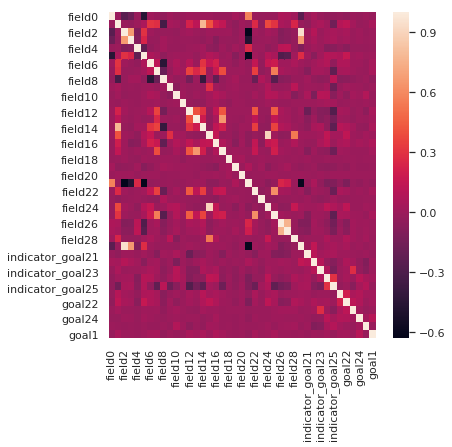

In [36]:
import seaborn as sns; sns.set()
#X, y = prepare_data(df_train)
ax = sns.heatmap(X.corr())

In [37]:
X.corr().nlargest(10)

TypeError: nlargest() missing 1 required positional argument: 'columns'

In [ ]:
corr = df_train.corr()
corr.field2['field29'], corr.field15['field24']

In [38]:
def add_polynomial_inner( X, poly ):
  X = X
  X = pd.DataFrame(poly.transform(X), index=X.index, columns = poly.get_feature_names(X.columns))
  return X
    
def add_polynomial(X_train, X_cv=None, degree=2):
  poly = sklearn.preprocessing.PolynomialFeatures(degree)
  poly.fit(X)
  
  X_train = add_polynomial_inner(X_train, poly)
  if X_cv is not None:
      X_cv = add_polynomial_inner(X_cv, poly)

  #poly_corrs = poly_features.corrwith(y).sort_values(ascending=False)
  #poly_corrs = poly_features.corrwith(y).nlargest(20)

  return X_train, X_cv, poly

def add_neighbors_inner( X, neigh ):
  X = X.copy()
  dists, _ = neigh.kneighbors(X, return_distance=True)
  X['K-mean'] = dists.mean(axis=1).reshape(-1, 1)
  X['K-max'] = dists.max(axis=1).reshape(-1, 1)
  return X

def add_neighbors(X_train, X_cv=None, n_neighbors=5):
  neigh = skl.neighbors.NearestNeighbors(n_neighbors=n_neighbors, n_jobs=-1)
  neigh.fit(X_train)

  X_train = add_neighbors_inner(X_train, neigh)
  if X_cv is not None:
      X_cv = add_neighbors_inner(X_cv, neigh)

  return X_train, X_cv, neigh

In [39]:
def estimate(X, y, model, plot=True):
  X_train, X_cv, y_train, y_cv = train_test_split(X, y, random_state=RS, shuffle=True)
  
  '''
  # apply class weights
  class_weights = list(skl.utils.class_weight.compute_class_weight('balanced', np.unique(y_train), y_train.values.ravel()))
  w_array = pd.Series(np.ones(y_train.shape[0], dtype = 'float32'), index=y_train.index)\
                    .apply(lambda x: class_weights[0] if x==0 else class_weights[1])
  '''
  #try:
  #  sklearn.utils.validation.check_is_fitted(model, type(model).__name__, 'Model is not fitted')
  #except sklearn.utils.validation.NotFittedError:
  boosters = ['XGBClassifier', 'LGBMClassifier']
  if type(model).__name__ in boosters:
    print(0, end='')
    model.fit(X_train, y_train, 
              eval_set=[(X_cv, y_cv)],
              early_stopping_rounds=200,
              verbose=False,
              #sample_weight=w_array
              )
  else:
    print(1, end='')
    model.fit(X_train, y_train.values.ravel(), 
              #sample_weight=w_array
              )

  if plot == True:
    plot_cm_and_roc(model, X_train, y_train, 'train')
    plot_cm_and_roc(model, X_cv, y_cv, 'cv')

  return model

In [40]:
def fit_estimate( X, y, model_generator, n_folds = 5, n_neighbors=0, degree=0, plot=False):

  scores = []
  models = []
  neighbs = []
  polies = []

  folds = list(skl.model_selection.StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=RS).split(X, y))
  for j, (train_idx, val_idx) in enumerate(folds):

    X_train, X_cv = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_cv = y[train_idx], y[val_idx]

    if degree > 1:
      X_train, X_cv, poly = add_polynomial(X_train, X_cv, degree)
      polies.append(poly)
    
    if n_neighbors > 0:
      X_train, X_cv, neigh = add_neighbors(X_train, X_cv, n_neighbors)
      neighbs.append(neigh)

    model = model_generator()

    #try:
    #  sklearn.utils.validation.check_is_fitted(model, type(model).__name__, 'Model is not fitted')
    #except sklearn.utils.validation.NotFittedError:
    boosters = ['XGBClassifier', 'LGBMClassifier']
    if type(model).__name__ in boosters:
      model.fit(X_train, y_train, 
                eval_set=[(X_cv, y_cv)],
                early_stopping_rounds=200,
                verbose=False,
                #sample_weight=w_array
                )
    else:
      print(1, end='')
      model.fit(X_train, y_train.values.ravel(), 
                #sample_weight=w_array
                )

    if plot == True:  
      plot_cm_and_roc(model, X_cv, y_cv, 'cv')

    y_pred_cv = model.predict_proba(X_cv)
    # score = skl.metrics.roc_auc_score(keras.utils.to_categorical(y_cv), y_pred_cv) # works for multiclass
    score = skl.metrics.roc_auc_score(y_cv, y_pred_cv[:, 1]) # better one for binary
    scores.append(score)
    models.append(model)

  # estimate OOF
  model = models[np.argmax(scores)]

  X_oof, y_off = prepare_data(df_oof)
  if n_neighbors > 0:
    neigh = neighbs[np.argmax(scores)]
    X_oof = add_neighbors_inner(X_oof, neigh)

  plot_cm_and_roc(model, X_oof, y_off, 'oof')
  pred = model.predict_proba(X_oof)
  oof = skl.metrics.roc_auc_score(y_off, pred[:, 1])
  del X_oof
  
  print(f'# {type(model).__name__} RS:{RS} \
          {n_folds}x CV: {np.mean(scores):.5f} ± {np.std(scores):.5f} \
          OOF: {oof:.5f}')
  
  return scores, models, neighbs, polies

In [41]:
def plot_permutation_importance(model, X_test, y_test, X_cv=None, y_cv=None):
  result = permutation_importance(model, X_test, y_test.values.ravel(), n_repeats=10, random_state=RS)
  sorted_idx = result.importances_mean.argsort()

  if  X_cv is None:
    fig, ax = plt.subplots(figsize=(15,5))
    ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_test.columns[sorted_idx])
    ax.set_title("Permutation Importance of each feature")
    ax.set_ylabel("Features")
    fig.tight_layout()
  else:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,4))
    ax1.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_test.columns[sorted_idx])
    ax1.set_title("Test Permutation Importance of each feature")
    ax1.set_ylabel("Features")

    result = permutation_importance(model, X_cv, y_cv.values.ravel(), n_repeats=10, random_state=RS)
    sorted_idx = result.importances_mean.argsort()

    ax2.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_test.columns[sorted_idx])
    ax2.set_title("CV Permutation Importance of each feature")
    ax2.set_ylabel("Features")

    fig.tight_layout()

  plt.show()

def plot_cm_and_roc(model, X, y, title=''):

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,4))
  fig.patch.set_facecolor((1.0, 1.0, 1.0))
  fig.suptitle(f'{type(model).__name__} {title}')
  skl.metrics.plot_confusion_matrix(model, X, y, cmap=plt.cm.Blues, ax=ax1)
  skl.metrics.plot_roc_curve(model, X, y, ax=ax2)
  '''
  pred_proba = model.predict_proba(X, ntree_limit=model.best_ntree_limit)
  fig = plt.figure(figsize=(15,4))
  fig.suptitle(f'{type(model).__name__} title')

  ax1 = fig.add_subplot(1, 2, 1)
  skplt.metrics.plot_confusion_matrix(y, pred_proba.argmax(axis=1), ax=ax1)
  ax2 = fig.add_subplot(1, 2, 2)
  skplt.metrics.plot_roc(y, pred_proba, ax=ax2)
  '''
def oof_estimate_plot(model):
  X_oof, y_off = prepare_data(df_oof)
  plot_cm_and_roc(model, X_oof, y_off, 'oof')

  if hasattr(model, 'best_ntree_limit'): pred = model.predict_proba(X_oof, ntree_limit=model.best_ntree_limit) 
  else: pred = model.predict_proba(X_oof)

  oof = skl.metrics.roc_auc_score(y_off, pred[:, 1])
  del X_oof
  return oof

def plot_cv_scores(scores, label='', ax=None):
  # plot CV scores
  if ax is None:
    plt.figure()
    plt.xlabel('Number of folds')
    plt.ylabel('Cross validation score')
    plt.plot(range(1, len(scores) + 1), scores, label=label)
    plt.legend()
    plt.show()
  else:
    ax.plot(range(1, len(scores) + 1), scores, label=label)
    ax.legend()

def plot_history(history, metric_names):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.subplots(figsize=(18,6))

  num_plots = len(metric_names)

  for i in range(num_plots):
    plt.subplot(1,num_plots,i+1)
    plt.xlabel('Epoch')
    plt.ylabel(metric_names[i])
    plt.plot(hist['epoch'], hist[metric_names[i]],
            label='Train %s' % metric_names[i])
    plt.plot(hist['epoch'], hist['val_%s' % metric_names[i]],
            label = 'Val %s' % metric_names[i])
    plt.legend()
  
  plt.show()

In [42]:
def add_aggregates(X, aggs=[], cols=[]):

  if len(aggs) == 0:
    aggs = ['std', 'sum', 'max', 'min', 'mean', 'count']

  if len(cols) == 0:
    cols = list(filter(lambda x: 'field' in x, X.columns))

  # add aggregates for userid
  grouped_by = X.groupby('userid')
  all_features = []
  
  # add count
  if 'count' in aggs:
    grouped = grouped_by.agg({'userid': 'count'})
    grouped.columns = ['count']
    all_features.append( grouped )
    aggs.remove('count')
  
  for col in cols:
    grouped = grouped_by.agg({col: aggs}) 
    grouped.columns = ["_".join(x) for x in grouped.columns.ravel()]
    all_features.append(grouped)

  if len(all_features)>0:
    all_features = pd.concat(all_features, axis=1)
    X = X.merge(all_features, on=('userid'))

  X.fillna(0, inplace=True)

  return X.drop(['userid'], axis=1)

def check_aggregates_result():
  a = df_train.groupby('userid', as_index=False).count()
  a = a[a.field0 == 5]
  a = df_train.loc[df_train.userid.isin([*a.userid])]
  #print(a.iloc[1].userid)
  a = a[a.userid == a.iloc[0].userid]

  return add_aggregates(a, cols=['field0'])
  
check_aggregates_result()

,field0,field1,field2,field3,field4,field5,field6,field7,field8,field9,...,goal23,goal24,goal25,goal1,count,field0_std,field0_sum,field0_max,field0_min,field0_mean
0,0,-8,8,9,1,1,0,1,1,0,...,0,0,0,0,5,33.261088,143,71,0,28.600000
1,71,-8,1,1,4,0,0,1,1,0,...,0,0,0,0,5,33.261088,143,71,0,28.600000
2,57,-9,11,12,3,0,0,1,1,0,...,0,0,0,0,5,33.261088,143,71,0,28.600000
3,0,-9,1,1,5,0,0,1,1,0,...,0,0,0,0,5,33.261088,143,71,0,28.600000
4,15,-9,9,10,2,0,0,1,1,0,...,0,0,0,0,5,33.261088,143,71,0,28.600000


In [43]:
def to_buckets(X, bins):
  return pd.cut(X, 10, labels=False)


In [44]:
print(skl.utils.class_weight.compute_class_weight('balanced', np.unique(y), y.values.ravel()))
counts = np.unique(y, return_counts=True)[1]
print(counts[0]/counts[1])

[ 0.51131885 22.58704557]
44.174091141833074


In [45]:
def get_best_params_xgbc():
  estimators = 298
  return {'base_score': 0.9883241431311958, 
  'booster': 'gbtree',
  'colsample_bylevel': 0.8954745282201794, 
  'colsample_bynode': 0.9053728787963939, 
  'colsample_bytree': 0.37737648074076036, 
  'gamma': 51, 
  'learning_rate': 0.06869149756603576, 
  'max_delta_step': 22, 
  'max_depth': 4, 
  'min_child_weight': 0.8940873051252118, 
  'missing': None,
  'n_estimators': estimators, 
  'nthread': None,
  'objective': 'binary:logistic',
  'random_state': RS,
  'reg_alpha': 0.2901487558842103, 
  'reg_lambda': 0.7240220329478356, 
  'scale_pos_weight': 0.11997115325466545,  #0.04082
  'seed': None,
  'silent': None,
  'subsample': 0.699092108437742,
  'verbosity': 0,
  # If there’s more than one metric in the eval_metric parameter given in params, the last metric will be used for early stopping
  'eval_metric': ['logloss', 'auc'],
  # 'rmse', 'rmsle', 'mae', 'logloss', 'error', 'error@t', 'merror', 'mlogloss', 'auc', 'aucpr', 'ndcg', 'map', 'ndcg@n', 'ndcg@n', 'ndcg-', 'map-', 'ndcg@n-', 'ndcg@n-'
  'tree_method': 'gpu_hist',
  'updater': 'grow_gpu_hist',
  'predictor': 'gpu_predictor'
  }

def get_best_params_lgbm():
  estimators = 203
  return {'boosting_type': 'gbdt',
    'class_weight': None,
    'colsample_bytree': 0.3811304824216669,
    'importance_type': 'split',
    'learning_rate': 0.016659893432998896,
    'max_depth': 20,
    'metric': ['logloss', 'auc'],
    'min_child_samples': 12,
    'min_child_weight': 0.0036350360157623163,
    'min_split_gain': 0.9619961904304549,
    'n_estimators': estimators,
    'n_jobs': -1,
    'num_leaves': 32,
    'objective': 'binary',
    'random_state': RS,
    'reg_alpha': 0.8022751137716411,
    'reg_lambda': 0.8186913351852023,
    'silent': True,
    'subsample': 0.5967826661188248,
    'subsample_for_bin': 200000,
    'subsample_freq': 14
    }


In [48]:
def prepare_data( data, undersample=0 ):

  X = data.copy()
  y = []

  if undersample > 0:
    # Separate majority and minority classes
    df_majority = X[X['goal1']==0]
    df_minority = X[X['goal1']==1]
    
    n_samples = math.floor( X['goal1'].sum() * undersample )

    # Downsample majority class
    df_majority_downsampled = resample(df_majority, 
                                    replace=False,    # sample without replacement
                                    n_samples=n_samples,     # to match minority class
                                    random_state=RS) # reproducible results
    
    # Combine minority class with downsampled majority class
    X = pd.concat([df_majority_downsampled, df_minority])# Separate majority and minority classes

  if  'goal1' in X.columns:
    y = X[['goal1']].astype(np.float32)

  FTS = list(filter(lambda x: 'field' in x, data.columns))
  X = X[FTS].astype(np.float32)
  '''
  # drop overfitting fts
  #X.drop(['field16'], axis=1, inplace=True)

  # add polimonial
  X['field7_field16'] = X['field7'] * X['field16']
  X['field16_field17'] = X['field16'] * X['field17']
  #X['field16_field25'] = X['field16'] * X['field25']
  X['field12_field16'] = X['field12'] * X['field16']
  X['field7_field12'] = X['field7'] * X['field12']
  X['field12_field25'] = X['field12'] * X['field25']

  # drop unimportant or negatively impacting
  X.drop(['field0', 'field29', 'field28'], axis=1, inplace=True)

  X = vectorize(X, ['field21']) #, 'field5', 'field7', 'field8', 'field9', 'field10', 'field18', 'field19', 'field20', 'field27'])
  X.drop(['field21_1'], axis=1, inplace=True)

  #X.drop(['field5_1', 'field7_1', 'field8_1', 'field9_2', 'field9_3', 'field9_4', 'field10_1', 'field19_0', 'field19_7', 'field19_8', 'field27_3'], axis=1, inplace=True)
  '''

  return X, y

In [49]:
def check_agregates_score():
  AGGREGATES = ['count', 'std', 'sum', 'min', 'max', 'mean']

  FTS = list(filter(lambda x: 'field' in x, df_train.columns))
  scores = []
  attrs = []

  X_, y = prepare_data(df_train)
  model = estimate(X_, y, XGBClassifier(**get_best_params_xgbc()), plot=False)
  if hasattr(model, 'best_ntree_limit'): scores.append(model.best_score)
  if hasattr(model, 'best_score_'): scores.append(model.best_score_['valid_0']['auc'])
  attrs.append(('baseline', ))

  grouped_by = df_train.groupby('userid')
  for col in tqdm(FTS):
    for agg in AGGREGATES:
      X_ = add_aggregates(df_train, aggs=[agg], cols=[col])
      X_, y = prepare_data(X_)
      #model = estimate(X_, y, LGBMClassifier(**get_best_params_lgbm()), plot=False)
      model = estimate(X_, y, XGBClassifier(**get_best_params_xgbc()), plot=False)
      if hasattr(model, 'best_ntree_limit'): scores.append(model.best_score)
      if hasattr(model, 'best_score_'): scores.append(model.best_score_['valid_0']['auc'])
      attrs.append((agg, col))

  arr = np.array(scores)
  for i in arr.argsort()[-10:][::-1]:
    print(scores[i], attrs[i])

check_agregates_score()

0[11:51:47] DANGER AHEAD: You have manually specified `updater` parameter. The `tree_method` parameter will be ignored. Incorrect sequence of updaters will produce undefined behavior. For common uses, we recommend using `tree_method` parameter instead.


0[11:51:49] DANGER AHEAD: You have manually specified `updater` parameter. The `tree_method` parameter will be ignored. Incorrect sequence of updaters will produce undefined behavior. For common uses, we recommend using `tree_method` parameter instead.
0[11:51:50] DANGER AHEAD: You have manually specified `updater` parameter. The `tree_method` parameter will be ignored. Incorrect sequence of updaters will produce undefined behavior. For common uses, we recommend using `tree_method` parameter instead.
0[11:51:52] DANGER AHEAD: You have manually specified `updater` parameter. The `tree_method` parameter will be ignored. Incorrect sequence of updaters will produce undefined behavior. For common uses, we recommend using `tree_method` parameter instead.
0[11:51:54] DANGER AHEAD: You have manually specified `updater` parameter. The `tree_method` parameter will be ignored. Incorrect sequence of updaters will produce undefined behavior. For common uses, we recommend using `tree_method` paramet

## Importance

['field12*field27', 'field16*field8', 'field12*field25', 'field1+field22']


In [50]:
xgb.plot_importance(model)
#xgb.plot_tree(model, num_trees=10)

importance = model.get_booster().get_score(importance_type='weight')
imp_sorted = sorted(importance.items(), key = lambda kv: (kv[1], kv[0]), reverse=True)
imp_filtered = list(filter(lambda kv: kv[1] > 36, imp_sorted))
print([x[0] for x in imp_filtered])

NameError: name 'model' is not defined

In [ ]:
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(30).plot(kind='barh')
print(feat_importances.nlargest(30).index)

In [ ]:
X, y = prepare_data( df_train)

from sklearn.utils import all_estimators

def_params = {
    'random_state': RS,
    'n_jobs': -1
}

estimators = all_estimators(type_filter='classifier')
for name, class_ in estimators:
  print(class_)
  #try:
  #  model = estimate(X, y, class_());
  #except:
  #  pass

In [ ]:
def prepare_data( data ):
  X = data[FTS]
  y = []

  if TARGET in data.columns: y = data[TARGET] #.values.ravel()
  #X = X.drop(['field5', 'field20'], axis=1)
  #cols = ['field10', 'field14'] # lb 0.673564
  #cols = ['field5', 'field20', 'field18', 'field27', 'field29', 'field10', 'field13']
  #cols = ['field5', 'field18', 'field20', 'field27', 'field29'] # lb 0.675374
  #cols = ['field20', 'field23']
  #cols = ['field5', 'field20'] # lb 0.674808
  #cols = ['field5'] # lb 0.675084
  #cols = ['field4', 'field5', 'field9', 'field10', 'field13', 'field15', 'field17', 'field22', 'field23', 'field24', 'field26'] # 0.673498

  #X = add_linear(X, ['field0'])

  #X['field12*field27'] = X['field12'] * X['field27']
  #X['field16*field8'] = X['field16'] * X['field8']
  #X['field12*field25'] = X['field12'] * X['field25']
  #X['field1+field22'] = X['field1'] + X['field22']

  cols = []
  #X = add_aggregates(data, aggs=['mean'], cols=['field0'])

  return X.drop(cols, axis=1), y

## Recursive Feature Elimination

In [ ]:
%%time
from sklearn.feature_selection import RFECV
# XGBClassifier CV: 0.6784501167635486 ± 0.01855717343073274 OOF: 0.6849985940210219 ~['field5', 'field20'] Baseline
# XGBClassifier CV: 0.6862505904663256 ± 0.0010323194363471226 OOF: 0.7056287931991523 10f, all fts 0.675026 lb

# XGBClassifier RS:77           5x CV: 0.68740 ± 0.00071           OOF: 0.68938           ~[]
# XGBClassifier RS:77 10x CV: 0.68861 ± 0.00071           OOF: 0.68378 ~['field5']

X, y = prepare_data( df_train )
n_folds = 2
rfe = RFECV(XGBClassifier(**get_best_params_xgbc()),
#rfe = RFECV(LGBMClassifier(**get_best_params_lgbm()),
            cv=StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=RS), 
            scoring='roc_auc', verbose=1, min_features_to_select=20, step=1, n_jobs=-1)
rfe.fit(X, y)

model = rfe

print(f'# {type(rfe.estimator_).__name__} RS:{RS} {n_folds}x CV: {np.mean(rfe.grid_scores_):.5f} ± {np.std(rfe.grid_scores_):.5f} \
          OOF: {oof_estimate_plot(rfe):.5f} ~{X.iloc[:, ~rfe.support_].columns.tolist()}')

print(f'Optimal number of features :{rfe.n_features_}')
plt.figure()
plt.xlabel('Number of features selected')
plt.ylabel('Cross validation score')
plt.plot(range(rfe.min_features_to_select, len(rfe.grid_scores_) + rfe.min_features_to_select), rfe.grid_scores_)
plt.show()

KeyboardInterrupt: ignored

In [ ]:
# estimate OOF
oof = oof_estimate_plot(model)

In [51]:
cols = X.iloc[:, rfe.support_].columns.tolist()
cols = [x for _,x in sorted(zip(rfe.ranking_,cols))]
print(f'Keep: {cols}')

NameError: name 'rfe' is not defined

In [52]:
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

## ExhaustiveFeatureSelector

In [ ]:
%%time
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
# EFS 28: Remove: ['field10', 'field14'], 0.6889053714968825, 5f
# XGBClassifier RS:77 3x CV: 0.68726 (29-30) ~['field3']
# XGBClassifier RS:77 3x CV: 0.68811 (28-30) ~['field0', 'field13']

X, y = prepare_data( df_train ) 
n_folds = 3
efs1 = EFS(XGBClassifier(**get_best_params_xgbc()), 
           min_features=28,
           max_features=30,
           scoring='roc_auc',
           print_progress=True,
           cv=list(StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=RS).split(X,y)),
           n_jobs=-1
           )
efs1 = efs1.fit(X, y)

print(f'# {type(model).__name__} RS:{RS} {n_folds}x CV: {efs1.best_score_:.5f} \
        ({efs1.min_features}-{efs1.max_features}) ~{[x for x in FTS if x not in efs1.best_feature_names_]}')

## SequentialFeatureSelector

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  88 out of  88 | elapsed:  3.2min finished

[2019-12-18 13:44:48] Features: 1/35 -- score: 0.6322793991159648[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  87 out of  87 | elapsed:  3.1min finished

[2019-12-18 13:47:55] Features: 2/35 -- score: 0.6628190940125211[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  86 out of  86 | elapsed:  3.5min finished

[2019-12-18 13:51:24] Features: 3/35 -- score: 0.6683265355095487[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  85 out o

<Figure size 864x648 with 0 Axes>

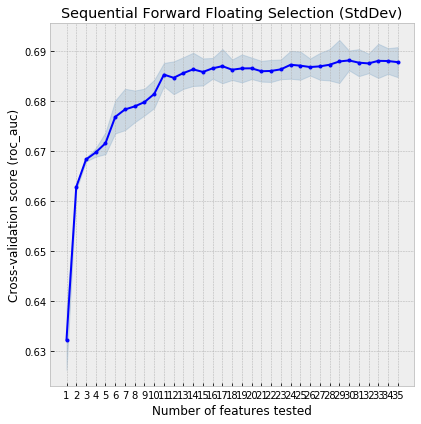

0.6881440619914809
Remove: ['field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field15', 'field16', 'field17', 'field19', 'field20', 'field23', 'field24', 'field26', 'field29']
CPU times: user 38.6 s, sys: 7.34 s, total: 45.9 s
Wall time: 1h 53min 25s


In [ ]:
%%time
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

X, y = prepare_data( df_train ) 
n_folds=2
sfs1 = SFS(XGBClassifier(**get_best_params_xgbc()), 
           k_features=(17, 35), 
           forward=True,
           floating=False, 
           verbose=2,
           scoring='roc_auc', 
           cv=list(StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=RS).split(X,y)),
           n_jobs=-1,
           )
sfs1 = sfs1.fit(X, y)

plt.figure(figsize=(12, 9))
fig1 = plot_sfs(sfs1.get_metric_dict(), kind='std_dev', marker='.', ylabel='Cross-validation score (roc_auc)')
plt.title('Sequential Forward Floating Selection (StdDev)')
plt.xlabel('Number of features tested')
plt.ylabel('Cross-validation score (roc_auc)')
plt.tight_layout()
#plt.show()
plt.show(block=False)

print(sfs1.k_score_)
print(f'Remove: {[x for x in FTS if x not in sfs1.k_feature_names_]}')

fname = os.path.join(OTT_PATH, 'SFS_set_linear_30fts_5f.txt')
with open(fname, 'w') as text_file:
  print(f'sfs1.k_score_: {sfs1.k_score_}', file=text_file)
  print(f'sfs1.k_feature_names_: {sfs1.k_feature_names_}', file=text_file)
  print(f'Remove: {[x for x in FTS if x not in sfs1.k_feature_names_]}', file=text_file)
  print(f'sfs1.subsets_: {sfs1.subsets_}', file=text_file)

#files.download(text_file.name)

## SelectKBest

VarianceThreshold RS:7 10x CV: 0.68995 ± 0.01383 ~['field9']
SelectKBest RS:7 10x CV: 0.68876 ± 0.01364 ~[]
SelectFpr RS:7 10x CV: 0.68637 ± 0.01300 ~['field3', 'field4', 'field11', 'field19', 'field20', 'field23', 'field26', 'field27', 'field29']
SelectFdr RS:7 10x CV: 0.68430 ± 0.01154 ~['field3', 'field4', 'field9', 'field11', 'field19', 'field20', 'field23', 'field26', 'field27', 'field29']
SelectFwe RS:7 10x CV: 0.68404 ± 0.01065 ~['field2', 'field3', 'field4', 'field9', 'field11', 'field18', 'field19', 'field20', 'field23', 'field26', 'field27', 'field28', 'field29']


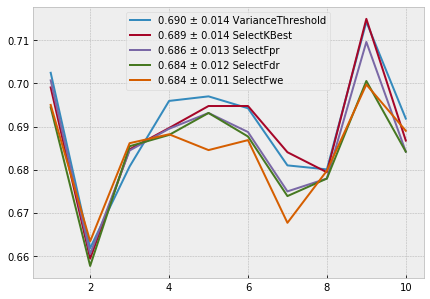

In [ ]:
from sklearn.feature_selection import SelectKBest, SelectFpr, SelectFdr, SelectFwe

X, y = prepare_data( df_train )
n_folds=10

models = []
models.append(sklearn.feature_selection.VarianceThreshold(threshold=(.9 * (1 - .9))).fit(X, y))
models.append(SelectKBest(score_func=sklearn.feature_selection.f_classif, k=X.shape[1]).fit(X, y))
models.append(SelectFpr(score_func=sklearn.feature_selection.f_classif).fit(X, y))
models.append(SelectFdr(score_func=sklearn.feature_selection.f_classif).fit(X, y))
models.append(SelectFwe(score_func=sklearn.feature_selection.f_classif).fit(X, y))

fig, ax = plt.subplots(figsize=(7,5))
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=RS)
for m in models:
  pipe = make_pipeline(m, XGBClassifier(**get_best_params_xgbc()))
  scores = cross_val_score(pipe, X, y, scoring='roc_auc', verbose=0, n_jobs=-1, cv=skf)
  #oof = oof_estimate_plot(pipe)
  print(f'{type(m).__name__} RS:{RS} {n_folds}x CV: {np.mean(scores):.5f} ± {np.std(scores):.5f} ~{[x for x in FTS if x not in X.columns[m.get_support(indices=True)]]}')
  label = f'{np.mean(scores):.3f} ± {np.std(scores):.3f} {type(m).__name__}'
  plot_cv_scores(scores, label, ax)

## 5 KFold estimation

['field12*field25']


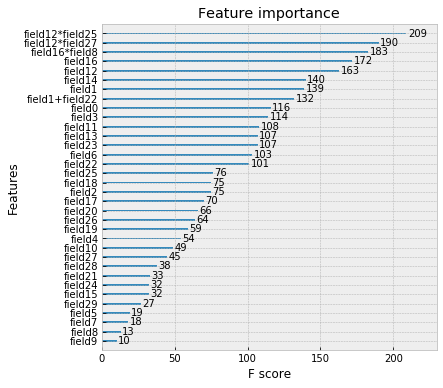

In [ ]:
xgb.plot_importance(model)
#xgb.plot_tree(model, num_trees=10)

importance = model.get_booster().get_score(importance_type='weight')
imp_sorted = sorted(importance.items(), key = lambda kv: (kv[1], kv[0]), reverse=True)
imp_filtered = list(filter(lambda kv: kv[1] > 200, imp_sorted))
print([x[0] for x in imp_filtered])

In [ ]:
X

,field0,field1,field2,field3,field4,field5,field6,field7,field8,field9,field10,field11,field12,field13,field14,field15,field16,field17,field18,field19,field20,field21,field22,field23,field24,field25,field26,field27,field28,field29,field12*field25
orderid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
126862,0,4,8,8,1,1,0,1,1,0,0,9,3,3,-4,4,23,1,5,5,7,1,31,14,3,1,1,1,1,3,3
195018,0,-2,8,8,1,1,0,2,1,0,0,3,3,3,1,1,10,1,5,4,1,1,149,8,1,3,1,1,0,3,9
36083,0,-4,6,6,1,1,0,1,1,0,0,19,38,62,-4,2,1,1,7,1,1,1,1,12,2,1,2,1,0,2,38
114781,0,-4,10,10,1,1,0,1,1,0,1,15,8,3,-5,2,2,1,2,1,4,1,17,10,2,1,1,1,0,4,8
74627,0,-7,8,9,1,1,0,1,1,1,0,13,21,3,-4,2,6,1,7,2,6,1,8,8,1,1,1,1,0,3,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107813,0,63,8,8,1,1,0,2,1,0,0,22,15,147,12,5,4,24,2,3,6,1,1,9,1,1,1,1,4,3,15
190420,14,-5,7,7,2,0,0,1,1,0,0,21,14,6,-1,1,4,1,1,1,5,1,1,17,1,1,3,1,0,3,14
192084,0,0,11,12,1,1,0,2,1,0,1,15,51,3,3,1,19,1,1,2,6,1,58,11,1,22,12,3,0,4,1122


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.4min finished


# XGBClassifier RS:77 5x CV: 0.68650 ± 0.00910 OOF: 0.68445 ~[]


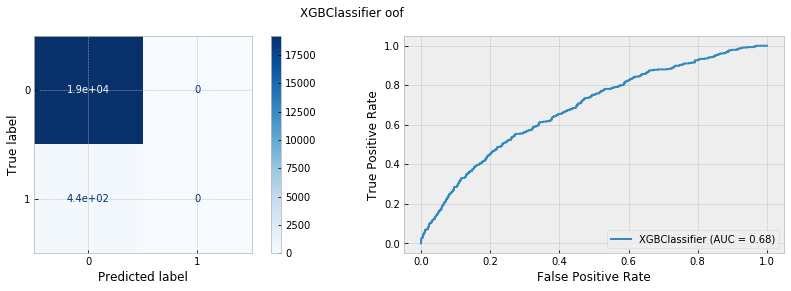

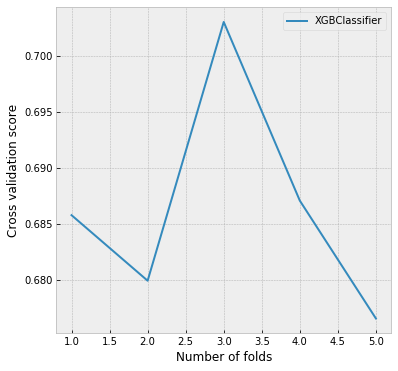

CPU times: user 32.1 s, sys: 23 s, total: 55.2 s
Wall time: 4min 21s


In [ ]:
%%time
# XGBClassifier RS:77 10x CV: 0.68632 ± 0.01004 OOF: 0.70910 ~[]
# XGBClassifier RS:77 10x CV: 0.68756 ± 0.01044 OOF: 0.70477 ~['field5', 'field18', 'field20', 'field27', 'field29']
# XGBClassifier RS:77 10x CV: 0.68658 ± 0.00903 OOF: 0.70523 ~['field10', 'field14']
# XGBClassifier RS:77 10x CV: 0.68625 ± 0.00975 OOF: 0.70811 ~['field5', 'field20'] 0.67496 lb 0.674808

# XGBClassifier RS:77 10x CV: 0.69002 ± 0.01538 OOF: 0.68585 ~['field5', 'field10', 'field13', 'field18', 'field20', 'field27', 'field29']
# XGBClassifier RS:77 10x CV: 0.68902 ± 0.01427 OOF: 0.68478 ~[]
# XGBClassifier RS:77 10x CV: 0.68977 ± 0.01474 OOF: 0.68665 ~['field5', 'field20'] lb 0.674808
# XGBClassifier RS:77 10x CV: 0.68882 ± 0.01386 OOF: 0.68944 ~['field5', 'field18', 'field20', 'field27', 'field29'] lb 0.675374
# XGBClassifier RS:77 10x CV: 0.68943 ± 0.01546 OOF: 0.68858 ~['field20']
# XGBClassifier RS:77 10x CV: 0.68901 ± 0.01439 OOF: 0.68648 ~['field5']
# XGBClassifier RS:77 10x CV: 0.68898 ± 0.01480 OOF: 0.68858 ~['field20', 'field23']
# XGBClassifier RS:77 10x CV: 0.68667 ± 0.01505 OOF: 0.68565 ~['field3', 'field4', 'field11', 'field19', 'field20', 'field23', 'field26', 'field27', 'field29']
# XGBClassifier RS:77 10x CV: 0.68575 ± 0.01453 OOF: 0.68365 ~['field3', 'field4', 'field9', 'field11', 'field19', 'field20', 'field23', 'field26', 'field27', 'field29']
# XGBClassifier RS:77 10x CV: 0.68275 ± 0.01404 OOF: 0.68180 ~['field2', 'field3', 'field4', 'field9', 'field11', 'field18', 'field19', 'field20', 'field23', 'field26', 'field27', 'field28', 'field29']
# XGBClassifier RS:77 10x CV: 0.69106 ± 0.01437 OOF: 0.68379 ~['field10', 'field14'] lb 0.673564
# XGBClassifier RS:77 10x CV: 0.68885 ± 0.01602 OOF: 0.68465 ~['field4', 'field5', 'field9', 'field10', 'field13', 'field15', 'field17', 'field22', 'field23', 'field24', 'field26']

X, y = prepare_data(df_train)
n_folds = 5
        
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=RS)
model = XGBClassifier(**get_best_params_xgbc())
scores = cross_val_score(model, X, y, scoring='roc_auc', verbose=1, n_jobs=-1, cv=skf)

model.fit(X, y,
        eval_set=[prepare_data(df_oof)],
        early_stopping_rounds=200,
        verbose=False,
        eval_metric = 'auc', 
        )

# estimate OOF
oof = oof_estimate_plot(model)
print(f'# {type(model).__name__} RS:{RS} {n_folds}x CV: {np.mean(scores):.5f} ± {np.std(scores):.5f} OOF: {oof:.5f} ~{[x for x in FTS if x not in X.columns]}')

plot_cv_scores(scores, type(model).__name__)

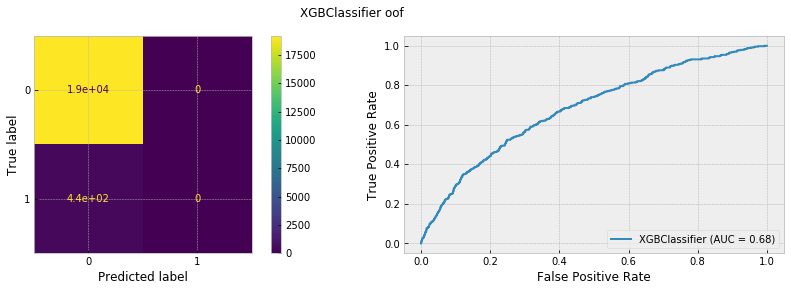

# XGBClassifier RS:77           5x CV: 0.68788 ± 0.00740           OOF: 0.68238


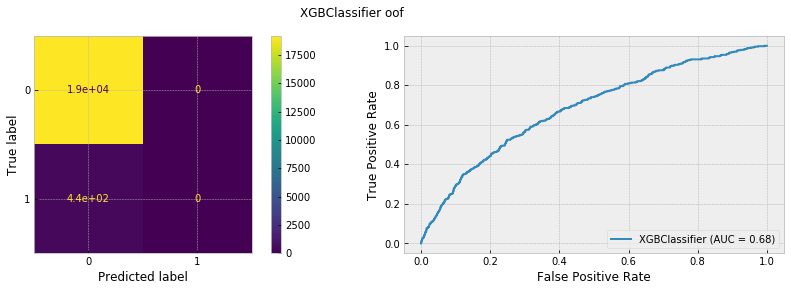

# XGBClassifier RS:77         10x CV: 0.68788 ± 0.00740         OOF: 0.68238 ~['field10', 'field14']


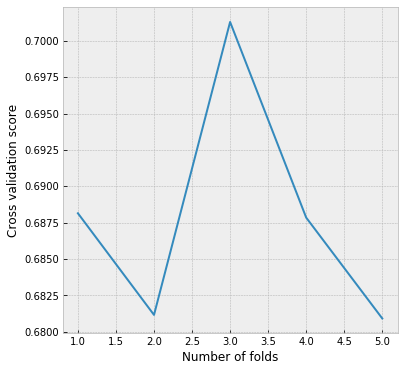

CPU times: user 10.4 s, sys: 1.8 s, total: 12.2 s
Wall time: 12.2 s


In [ ]:
# baseline: 0.6909 ± 0.0085.
# XGBClassifier CV: 0.6885 ± 0.0078 OOF: 0.6852 - baseline
# XGBClassifier CV: 0.6890 ± 0.0083 OOF: 0.6871 - ~['field5', 'field20']
# XGBClassifier CV: 0.6884 ± 0.0090 OOF: 0.6878 - ~['field8', 'field10', 'field17']

# XGBClassifier RS:77 5x CV: 0.68655 ± 0.00717 OOF: 0.70138 ~['field10', 'field14']


%%time
X, y = prepare_data(df_train)


try:
  if len(models) > 0:
    for m in models: del m
    models = []
except:
  pass

scores, models, neighbs, polies = fit_estimate(X, y,
        #lambda: skl.ensemble.BaggingClassifier(XGBClassifier(**get_best_params_xgbc()), n_estimators=10, random_state=RS, oob_score=True),
        lambda: XGBClassifier(**get_best_params_xgbc()), 
        n_folds=5, degree=0, n_neighbors=0) #, plot=True)

model = models[np.argmax(scores)]
#neigh = neighbs[np.argmax(scores)]

# estimate OOF
oof = oof_estimate_plot(model)
print(f'# {type(model).__name__} RS:{RS} \
        {n_folds}x CV: {np.mean(scores):.5f} ± {np.std(scores):.5f} \
        OOF: {oof:.5f} ~{[x for x in FTS if x not in X.columns]}')

plot_cv_scores(scores)

del X

In [ ]:
a = df_train.groupby('userid', as_index=False).count()
a = a[a.field0 > 1]
a = df_train.loc[df_train.userid.isin([*a.userid])]
a.goal1.hist()

In [ ]:
shap_sum = np.abs(shap_values).mean(axis=0)
importance_df = pd.DataFrame([X.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False)
importance_df

,column_name,shap_importance
17,field7_field16,0.224827
22,field21_0,0.115388
34,field10_0,0.101748
19,field12_field16,0.088139
21,field12_field25,0.080946
...,...,...
35,field10_1,0.000000
32,field9_3,0.000000
51,field19_8,0.000000
50,field19_7,0.000000


In [ ]:
import shap
%time shap_values = shap.TreeExplainer(model).shap_values(X)
shap.summary_plot(shap_values, X)

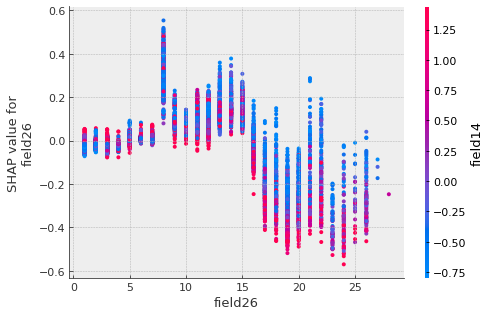

In [ ]:
shap.dependence_plot("field26", shap_values, X)

In [ ]:
X, y = prepare_data( df_train )

import seaborn as sns
Y = X.head(2000)
Y['goal1'] = y.values.ravel()
sns.pairplot(Y, diag_kind="kde")

## SearchGridCV

In [ ]:
X, y = prepare_data( df_train )

params = { 
  'metric': ['rmse', 'rmsle', 'mae', 'logloss', 'error', 'error@t', 'merror', 
                  'mlogloss', 'auc', 'aucpr', 'ndcg', 'map', 'ndcg@n', 'ndcg@n', 
                  'ndcg-', 'map-', 'ndcg@n-', 'ndcg@n-']

  }

gs = GridSearchCV(LGBMClassifier(**get_best_params_lgbm()),
                  params, 
                  cv=KFold( n_splits = 5, shuffle=True, random_state=RS),
                  verbose=10, 
                  n_jobs=-1,
                  scoring='roc_auc')
gs.fit(X, y)
print( gs.best_params_ )
print( gs.best_score_ )

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   35.6s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   54.6s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  3.3min finished
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

{'metric': 'rmse'}
0.6785321104213122


In [ ]:
X, y = prepare_data( df_train )

X_train, X_cv, y_train, y_cv = train_test_split(X, y, random_state=RS, shuffle=True)

model = XGBClassifier(**get_best_params()).fit(X, y.values.ravel())

plot_permutation_importance(model, X_train, y_train, X_cv, y_cv)

estimate(X, y, model);

In [ ]:
X.columns[sorted_idx]

Index(['field5', 'field19', 'field7', 'field2', 'field15', 'field8', 'field20',
       'field0', 'field16', 'field4', 'field9', 'field17', 'field18', 'field1',
       'field14', 'field11', 'field12', 'field6', 'field21', 'field13',
       'field3', 'field10'],
      dtype='object')

## RandomizedSearchCV

In [ ]:
%%time

from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt   
import sklearn.ensemble

X, y = prepare_data(df_train)

params = {'base_score': sp_randFloat(),
 'colsample_bylevel': sp_randFloat(),
 'colsample_bynode': sp_randFloat(),
 'colsample_bytree': sp_randFloat(),
 'gamma': sp_randInt(0, 100),
 'learning_rate': sp_randFloat(),
 'max_delta_step': sp_randInt(0, 100),
 'max_depth': sp_randInt(2, 10),
 'min_child_weight': sp_randFloat(),
 'n_estimators': sp_randInt(10, 500),
 'reg_alpha': sp_randFloat(),
 'reg_lambda': sp_randFloat(),
 'scale_pos_weight': sp_randFloat(),
 'subsample': sp_randFloat(),
 }

params_lgbm = {
  'colsample_bytree': sp_randFloat(),
  'learning_rate': sp_randFloat(),
  'max_depth': sp_randInt(2, 50),
  'min_child_samples': sp_randInt(2, 50),
  'min_child_weight': sp_randFloat(),
  'min_split_gain': sp_randFloat(),
  'n_estimators': sp_randInt(10, 500),
  'num_leaves': sp_randInt(1, 200),
  'reg_alpha': sp_randFloat(),
  'reg_lambda': sp_randFloat(),
  'subsample': sp_randFloat(),
  'subsample_freq': sp_randInt(0, 50),
  }

#clf = LGBMClassifier(**get_best_params_lgbm())
clf = XGBClassifier(**get_best_params_xgbc())
rs = RandomizedSearchCV(clf, 
                        param_distributions=params, 
                        cv=5, 
                        verbose=1, 
                        n_iter=500, 
                        scoring='roc_auc',
                        #n_jobs=-1
                        )
rs.fit(X, y.values.ravel())
print( rs.best_params_ )
print( rs.best_score_ )

with open('Randomized_5f_200iter.txt', 'w') as text_file:
  print(f"best_score_: {rs.best_score_}", file=text_file)
  print(f"best_params_: {rs.best_params_}", file=text_file)
  text_file.close()
files.download('Randomized_5f_200iter.txt')

In [ ]:
rs.best_estimator_.get_params()

In [ ]:
X_train.shape, X_cv.shape, 

((14116, 10, 30), (3529, 10, 30))

## Neural Networks

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 64)            24320     
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 64)            33024     
_________________________________________________________________
dense (Dense)                (None, 10, 2)             130       
Total params: 57,474
Trainable params: 57,474
Non-trainable params: 0
_________________________________________________________________
Train on 14116 samples, validate on 3529 samples
Epoch 1/500
14116/14116 [==============================] - 5s 364us/sample - loss: 0.4756 - sparse_categorical_crossentropy: 0.1316 - val_loss: 0.1167 - val_sparse_categorical_crossentropy: 0.1069
Epoch 2/500
14116/14116 [==============================] - 2s 159us/sample - loss: 0.1078 - sparse_categorical_crossentropy: 0.1041 - va

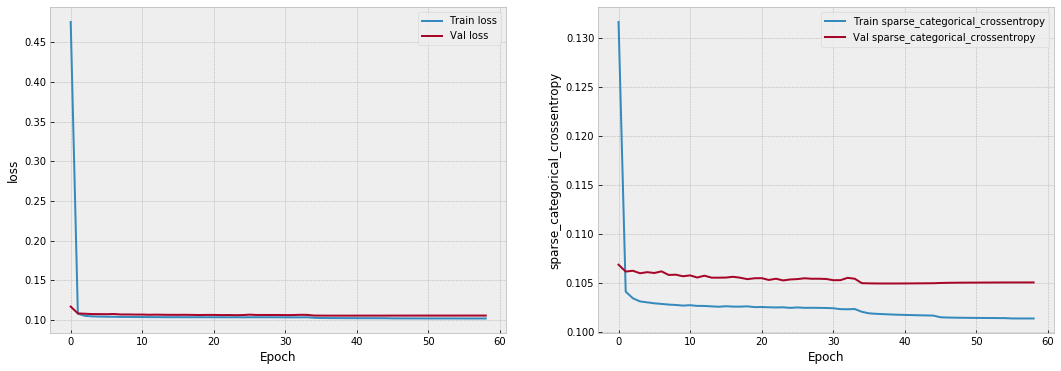

loss: 0.1053 sparse_categorical_crossentropy: 0.1049 


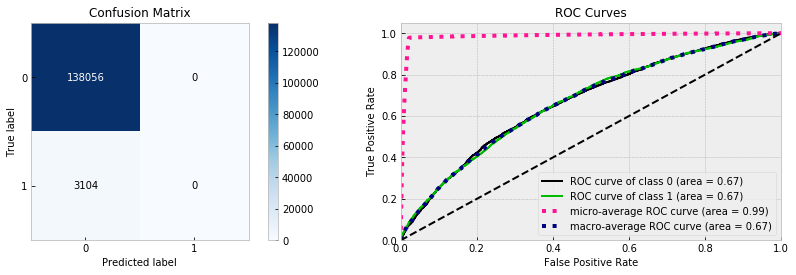

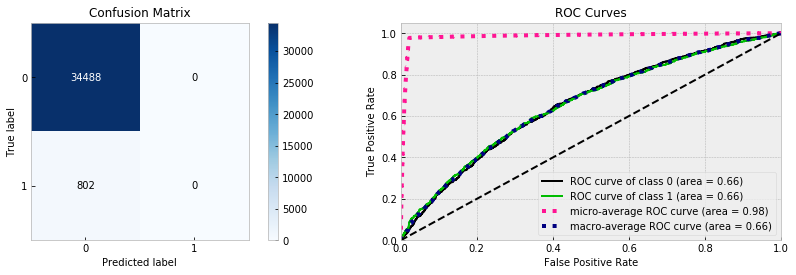

In [ ]:
tf.keras.backend.clear_session()

EPOCHS = 500
BS = 64
BLOCK=10

X, y = prepare_data(df_train)
X_train, X_cv, y_train, y_cv = train_test_split(X, y, random_state=RS, shuffle=False, test_size=0.2)
FEATURES_NUM = X_train.shape[1]

#center, scale = X_train.mean().values, X_train.std().values
#X_train = (X_train.values - center)/scale
#X_cv = (X_cv.values - center)/scale

X_train = X_train.values.reshape(-1, BLOCK, FEATURES_NUM)
y_train_ = y_train.reshape(-1, BLOCK, 1)

X_cv = X_cv.values.reshape(-1, BLOCK, FEATURES_NUM)
y_cv_ = y_cv.reshape(-1, BLOCK, 1)

weight_decay = 0.03
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(BLOCK, FEATURES_NUM)),
    tf.keras.layers.LSTM(64, return_sequences=True, kernel_regularizer=keras.regularizers.l2(weight_decay)),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dense(2, activation='softmax'),
  ])
optimizer=keras.optimizers.Adam(lr=1e-3)
model.compile(optimizer=optimizer, 
              metrics=[#tf.keras.metrics.AUC(), 
                      'sparse_categorical_crossentropy'
                      ], 
              loss='sparse_categorical_crossentropy'
              )
model.summary()
model.reset_states()

class ResetStatesCallback(keras.callbacks.Callback):
    def on_batch_begin(self, batch, logs):
        self.model.reset_states()

lr_schedule = keras.callbacks.ReduceLROnPlateau(verbose=0, factor=0.1, patience=10, monitor='val_loss', mode='min')
early_stop = keras.callbacks.EarlyStopping( patience=20, monitor='val_loss', mode='min' )
model_save = keras.callbacks.ModelCheckpoint( "my_checkpoint.h5", monitor='val_loss', save_best_only=True, mode='min' )
reset_states = ResetStatesCallback()

callbacks = [ early_stop, 
        model_save, 
        lr_schedule,
        reset_states
        ]

history = model.fit(X_train, y_train_,
          epochs=EPOCHS,
          batch_size=BS,
          shuffle=False,
          use_multiprocessing=True,
          verbose=1,
          validation_data=(X_cv, y_cv_),
          callbacks=callbacks)

model = keras.models.load_model('my_checkpoint.h5')

plot_history(history, model.metrics_names)

score = model.evaluate(X_cv, y_cv_, 
                        batch_size=BS, 
                        verbose=0,
                        use_multiprocessing=True)

metrics = ''
for i in range(len(model.metrics_names)):
  metrics += f'{model.metrics_names[i]}: {score[i]:.4f} '

print(metrics)

model.reset_states()

train_pred_proba = model.predict(X_train, use_multiprocessing=True)
train_pred_proba = train_pred_proba.reshape(-1, 2)
train_pred = train_pred_proba.argmax(axis=1)
cv_pred_proba = model.predict(X_cv, use_multiprocessing=True)
cv_pred_proba = cv_pred_proba.reshape(-1, 2)
cv_pred = cv_pred_proba.argmax(axis=1)

fig = plt.figure(figsize=(15,4))
ax1 = fig.add_subplot(1, 2, 1)
skplt.metrics.plot_confusion_matrix(y_train, train_pred, ax=ax1)
ax2 = fig.add_subplot(1, 2, 2)
skplt.metrics.plot_roc(y_train, train_pred_proba, ax=ax2)

fig = plt.figure(figsize=(15,4))
ax1 = fig.add_subplot(1, 2, 1)
skplt.metrics.plot_confusion_matrix(y_cv, cv_pred, ax=ax1)
ax2 = fig.add_subplot(1, 2, 2)
skplt.metrics.plot_roc(y_cv, cv_pred_proba, ax=ax2)
plt.show()

In [ ]:
model = keras.models.load_model('my_checkpoint.h5')


X_test, _ = prepare_data( df_test )
X_test = X_test[:(X_test.shape[0]//10)*10]
X_test = (X_test.values - center)/scale

X_test = X_test.reshape(-1, BLOCK, FEATURES_NUM)
test_pred_proba = model.predict(X_test, use_multiprocessing=True)
test_pred_proba = test_pred_proba.reshape(-1, 2)

zero = np.zeros(df_test.shape[0])
zero[:test_pred_proba.shape[0]] = test_pred_proba[:, 1]

pd.DataFrame(zero, columns=['proba'], index=df_test.index.rename('orderid')).to_csv('sub1.csv')

In [ ]:
test_pred

array([0.02045105, 0.02561184, 0.02155982, ..., 0.02158574, 0.01821708,
       0.01149145], dtype=float32)

## Submit the result

In [ ]:
model.best_ntree_limit

290

In [ ]:
X_test, _ = prepare_data( df_test )
#X_test = add_neighbors_inner(X_test, neigh)

if hasattr(model, 'best_ntree_limit'):
  print(0)
  proba = model.predict_proba(X_test, ntree_limit=model.best_ntree_limit)
else:
  print(1)
  proba = model.predict_proba(X_test)

pd.DataFrame(proba[:, 1], columns=['proba'], index=X_test.index.rename('orderid')).to_csv('sub1.csv')
files.download('sub1.csv')

1


In [ ]:
!zip sub1.csv.zip sub1.csv
files.download('sub1.csv.zip')

In [ ]:
pd.DataFrame(proba[:, 1], columns=['proba'], index=X_test.index.rename('orderid'))

In [ ]:
!pip3 install -q eli5
import eli5
from eli5.sklearn import PermutationImportance

In [ ]:
!pip3 install -q catboost
from catboost import CatBoostClassifier

     |████████████████████████████████| 63.6MB 124kB/s 


In [ ]:
!pip install -q shap

In [ ]:
kepler = pd.read_csv("../input/cumulative.csv")
kepler = (kepler
     .drop(['rowid', 'kepid'], axis='columns')
     .rename(columns={'koi_disposition': 'disposition', 'koi_pdisposition': 'predisposition'})
     .pipe(lambda df: df.assign(disposition=(df.disposition == 'CONFIRMED').astype(int), predisposition=(df.predisposition == 'CANDIDATE').astype(int)))
     .pipe(lambda df: df.loc[:, df.dtypes.values != np.dtype('O')])  # drop str columns
     .pipe(lambda df: df.loc[:, (df.isnull().sum(axis='rows') < 500).where(lambda v: v).dropna().index.values])  # drop columns with greater than 500 null values
     .dropna()
)

kepler_X = kepler.iloc[:, 1:]
kepler_y = kepler.iloc[:, 0]

os.path.join(
    
os.path.join(path, "User/Desktop", "file.txt")